In [1]:
import sys
import numpy as np # linear algebra
import matplotlib.pyplot as plt # picture
from math import sqrt
import openpyxl
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from xgboost import XGBClassifier

In [ ]:
"""
Objective
---------
Time-series cross-validation and classify the future index into wet/dry period

Noted
---------
Days between the first "wet" label and the first "dry" label will be determined into the wet period in each year

"""

cc = []
count = 0
ans_box = []
act_box = []
date_box = []
score_gain_box = []
score_cover_box = []
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(x):
    
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
    date_test = date[test_index]
    count = count + 1
    
    print("Training shape:", x_train.shape, "Testing shape:", y_test.shape)
    writer = pd.ExcelWriter('record//XGBoostClassify-6day-0601-1.xlsx')
    
    
    model = XGBClassifier(max_depth=256, learning_rate=0.01, n_estimators=512, importance_type = 'gain')
    model.fit(x_train, y_train)
    ans = model.predict(x_test)
    score_gain = model.feature_importances_
    model = XGBClassifier(max_depth=256, learning_rate=0.01, n_estimators=512, importance_type = 'cover')
    model.fit(x_train, y_train)
    score_cover = model.feature_importances_
    print("accuracy:",metrics.accuracy_score(y_test, ans))
    
    score_gain_box.extend(score_gain.reshape(-1))
    score_cover_box.extend(score_cover.reshape(-1))
    date_box.extend(date_test.reshape(-1))
    ans_box.extend(ans.reshape(-1))
    act_box.extend(y_test.reshape(-1))
    runoff = np.hstack(((np.array(ans_box)).reshape(-1,1),(np.array(act_box)).reshape(-1,1),(np.array(date_box)).reshape(-1,1)))
    runoffdata = pd.DataFrame(runoff)
    runoffdata.columns = ['Predict','Actual','date']
    runoffdata.to_excel(writer, 'ClassifyResult')
    
    score = np.hstack(((np.array(score_gain_box)).reshape(-1,1),(np.array(score_cover_box)).reshape(-1,1)))
    score_ = pd.DataFrame(score)
    score_.columns = ['gain','cover']
    score_.to_excel(writer,'score')
    
    writer.close()

E:\Anaconda3\envs\tensorflow-GPU\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


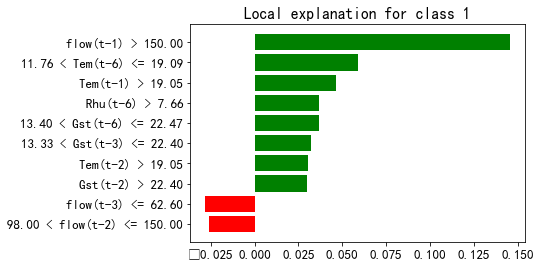

In [41]:
# lime explanation
import matplotlib.pyplot as plt  
plt.rc('font', family='SimHei', size=13)
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(x_test.values,
                                 feature_names=list(x_test.columns.values),
                                 class_names=[0,1])
exp = explainer.explain_instance(x_test.values[2], model.predict_proba)
fig = exp.as_pyplot_figure()